In [1]:
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

In [2]:
from impy.constants import *
from impy import models
from impy.kinematics import EventKinematics
from impy import impy_config, pdata

In [3]:
# Configuration options can be set via the config. It's a yaml file in impy/impy_config.yaml
impy_config["user_frame"] = 'center-of-mass'
impy_config['tau_stable'] = 10e-12
impy_config['pi0_stable'] = True
# impy_config['debug_level'] = 5

In [4]:
# Example: generating pseudorapidity (eta) and Feynman-x distributions 

In [5]:
n_bins = 30
# Grid for Feynman-x
bins = np.linspace(-1,1.,n_bins+1)
grid = 0.5*(bins[1:] + bins[:-1])
widths = np.diff(bins)

# Pseudorapidity
eta_bins = np.linspace(-7,7,n_bins+1)
eta_grid = 0.5*(eta_bins[1:] + eta_bins[:-1])
widths_eta = np.diff(eta_bins)

n_events = 10000

# We want to simulate pp interactions at 1 TeV center-of-mass

# The event kinematics objects define all properties of the simulations setup.
# Some generators (such as DPMJET) require a maximal energy and nucleus mass to be
# set during initialization. This fist object should define that boundary 
event_kinematics = EventKinematics(
    ecm= 1 * TeV,
    p1pdg=2212,
    p2pdg=2212
)

In [6]:
# Create instances of two different models

m1 = models.Sibyll21(event_kinematics)

m2 = models.Sibyll23d(event_kinematics)

 |                                                  |
 |                 S I B Y L L  2.1                 |
 |                                                  |
 |         HADRONIC INTERACTION MONTE CARLO         |
 |                        BY                        |
 |                   Ralph ENGEL                    |
 |           R.S. FLETCHER, T.K. GAISSER            |
 |               P. LIPARI, T. STANEV               |
 |                                                  |
 | Publication to be cited when using this program: |
 | R. Engel et al., Proc. 26th ICRC, 1 (1999) 415   |
 |                                                  |
 | last modified:  28. Sept. 2001 by R. Engel       |


 Table: J, sqs,  PT_cut,  SIG_tot,  SIG_inel,  B_el,  rho,  <n_s>,  <n_h>
 ------------------------------------------------------------------------
    1   1.000E+01    1.45   38.33   30.88   10.83  -0.185   1.964   0.003
    1   1.259E+01    1.49   38.27   31.16   11.10  -0.127   1.949   0.006


In [7]:
results = {}

for m in (m1, m2):
    model_name = m.__class__.__name__

    results[model_name] = {}

    # Storage for xf histograms
    pions = 0
    protons = 0
    negpions = 0

    # For all charged particles
    charged_eta = 0

    # This loop generates the events using the energy, projectile, target and frame defined by event kinematics object
    for event in tqdm(m(n_events)):
        # Filter the event stack for charged particles in final state. To include neutral use filter_final_state() instead.
        event.filter_final_state_charged()
        protons += np.histogram(event.xf[event.p_ids == 2212],bins=bins)[0]
        pions += np.histogram(event.xf[event.p_ids == 211],bins=bins)[0]
        negpions += np.histogram(event.xf[event.p_ids == -211],bins=bins)[0]

        # To select all charged particles don't filter for particle ID
        charged_eta += np.histogram(event.eta, bins=eta_bins)[0]

    for k, v in zip(("pi+", "p", "pi-"), (pions, protons, negpions)):
        results[model_name][k] = v /  widths / n_events

    results[model_name]["charged"] = charged_eta / widths_eta / n_events

10000it [00:03, 2886.85it/s]
10000it [00:03, 2657.78it/s]


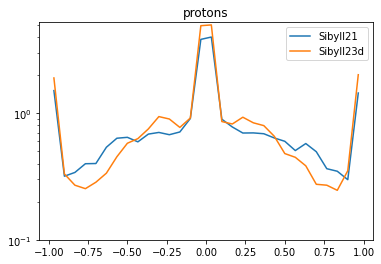

In [14]:
for model, r in results.items():
    plt.plot(grid, r["p"],label=model)
plt.title("protons")
plt.ylim(1e-1,)
plt.semilogy()
plt.legend();

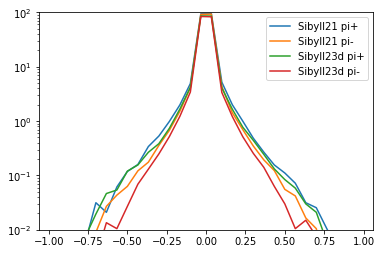

In [13]:
for model, r in results.items():
    plt.plot(grid, r["pi+"], label=f"{model} pi+")
    plt.plot(grid, r["pi-"], label=f"{model} pi-")

plt.ylim(1e-2,)
plt.semilogy()
plt.legend()

plt.ylim(1e-2,)
plt.semilogy()
plt.legend();

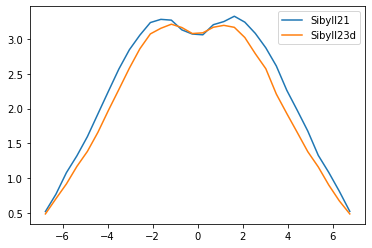

In [12]:
for model, r in results.items():
    plt.plot(eta_grid, r["charged"], label=model)
plt.legend();

In [16]:
# Looking at event lists for model 1

for event in m1(3):
    event.filter_final_state_charged()
    print('Event {5:4}   {0:8} {1:10} {2:10} {3:10} {4:10}'.format('pid', 'px', 'py', 'pz', 'e', event.nevent))
    for ip, (pid, x, y, z, e) in enumerate(zip(event.p_ids, event.px, event.py, event.pz, event.en)):
        print('   {5:4}: {0:8} {1:10.2e} {2:10.2e} {3:10.2e} {4:10.2e}'.format(pid, x, y, z, e, ip))

Event    0   pid      px         py         pz         e         
      0:     -211  -4.84e-02  -6.55e-01   1.24e+00   1.41e+00
      1:      211   5.04e-01  -7.05e-01   1.33e+00   1.60e+00
      2:     -321  -4.34e-01  -3.43e-01  -5.34e+00   5.39e+00
      3:     -321  -3.51e-01   1.90e-01  -1.07e+00   1.24e+00
      4:      211  -3.52e-02  -8.16e-02   1.38e-01   2.15e-01
      5:      211  -2.36e-01   3.29e-01  -4.86e+00   4.87e+00
      6:      211  -8.04e-01  -1.56e-01   6.38e+00   6.43e+00
      7:     -211   3.58e-01  -2.27e-01  -9.10e+00   9.11e+00
      8:      211  -5.25e-01  -4.12e-01  -1.29e+01   1.29e+01
      9:      211   1.76e-02   4.96e-01  -8.81e-01   1.02e+00
     10:     -211  -1.44e-01   1.57e-01   8.66e-02   2.69e-01
     11:     -211   3.60e-01  -2.10e-01  -6.02e+00   6.04e+00
     12:      321  -4.21e-01   1.18e-01  -1.31e+00   1.46e+00
     13:     -321   1.28e-01  -5.64e-01  -2.03e+00   2.18e+00
     14:     -211  -9.93e-02   5.15e-01  -7.80e+00   7.82e+00
    